## Lung Nodule Detection - Model Training Notebook

Step 1: Dataset Splitting

 We will divide the dataset into Train, Validation, and Test sets.
 
 Ensure a balanced distribution of nodules and non-nodules.

In [ ]:
import os
import shutil
import random

# Paths to normalized data
data_dir = "processed_data_normalized"
output_dir = "dataset_split"
os.makedirs(output_dir, exist_ok=True)

# Train-Validation-Test Split Ratio
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Categories (Nodules / Non-Nodules)
categories = ["nodules", "non_nodules"]


# Function to split data
def split_data():
    for category in categories:
        category_path = os.path.join(data_dir, category)
        files = os.listdir(category_path)
        random.shuffle(files)

        train_split = int(len(files) * train_ratio)
        val_split = train_split + int(len(files) * val_ratio)

        subsets = {
            "train": files[:train_split],
            "val": files[train_split:val_split],
            "test": files[val_split:],
        }

        for subset, subset_files in subsets.items():
            subset_dir = os.path.join(output_dir, subset, category)
            os.makedirs(subset_dir, exist_ok=True)

            for file in subset_files:
                src = os.path.join(category_path, file)
                dst = os.path.join(subset_dir, file)
                shutil.copy(src, dst)

    print("✅ Dataset splitting completed!")


split_data()

# Next steps: Model building and training setup

✅ Dataset splitting completed!


In [10]:
# ✅ 2️⃣ Custom Dataset Class for .pt Files
import torch
from torch.utils.data import Dataset, DataLoader


class LungNoduleDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.samples = []

        for category in ["nodules", "non_nodules"]:
            category_path = os.path.join(root_dir, category)
            if os.path.exists(category_path):
                for file in os.listdir(category_path):
                    if file.endswith(".pt"):  # Load only .pt files
                        self.samples.append(
                            (
                                os.path.join(category_path, file),
                                0 if category == "non_nodules" else 1,
                            )
                        )

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_path, label = self.samples[idx]
        image_tensor = torch.load(file_path)  # Load .pt file
        return image_tensor, torch.tensor(label, dtype=torch.long)

In [11]:
batch_size = 32

dataloaders = {
    "train": DataLoader(
        LungNoduleDataset(os.path.join("dataset_split", "train")),
        batch_size=batch_size,
        shuffle=True,
    ),
    "val": DataLoader(
        LungNoduleDataset(os.path.join("dataset_split", "val")),
        batch_size=batch_size,
        shuffle=False,
    ),
    "test": DataLoader(
        LungNoduleDataset(os.path.join("dataset_split", "test")),
        batch_size=batch_size,
        shuffle=False,
    ),
}

print("✅ Data loaders are ready!")

✅ Data loaders are ready!


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import timm
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

c:\Users\emada\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
c:\Users\emada\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
import timm
import torch.nn as nn

# Load Swin Transformer model
model = timm.create_model(
    "swin_tiny_patch4_window7_224", pretrained=True, num_classes=2
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

print("✅ Model loaded and ready for training!")

✅ Model loaded and ready for training!


In [13]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in dataloaders["train"]:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / len(dataloaders["train"])
        epoch_acc = correct / total
        print(
            f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}"
        )

    print("✅ Training complete!")


# Train the model
train_model(model, dataloaders, criterion, optimizer, num_epochs=10)

Epoch 1/10, Loss: 0.2599, Accuracy: 0.9414
Epoch 2/10, Loss: 0.1827, Accuracy: 0.9506
Epoch 3/10, Loss: 0.2457, Accuracy: 0.9506
Epoch 4/10, Loss: 0.2020, Accuracy: 0.9506
Epoch 5/10, Loss: 0.1931, Accuracy: 0.9506
Epoch 6/10, Loss: 0.2365, Accuracy: 0.9506
Epoch 7/10, Loss: 0.1576, Accuracy: 0.9506
Epoch 8/10, Loss: 0.2125, Accuracy: 0.9506
Epoch 9/10, Loss: 0.1702, Accuracy: 0.9506
Epoch 10/10, Loss: 0.1083, Accuracy: 0.9599
✅ Training complete!


### Evaluation

In [14]:
# ✅ 1️⃣ Validation & Test Evaluation

import torch.nn.functional as F


def evaluate_model(model, dataloader, dataset_type="Validation"):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    accuracy = correct / total
    print(f"✅ {dataset_type} Accuracy: {accuracy:.4f}")

    return all_labels, all_preds


# Evaluate on validation and test sets
val_labels, val_preds = evaluate_model(model, dataloaders["val"], "Validation")
test_labels, test_preds = evaluate_model(model, dataloaders["test"], "Test")

✅ Validation Accuracy: 0.9565
✅ Test Accuracy: 0.9429


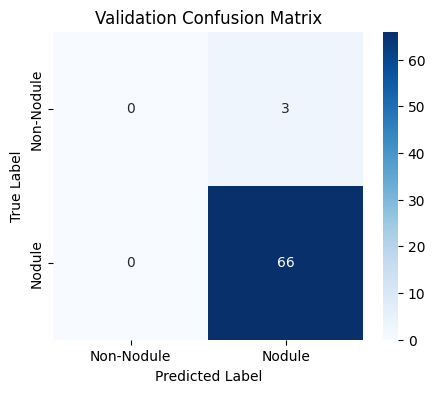

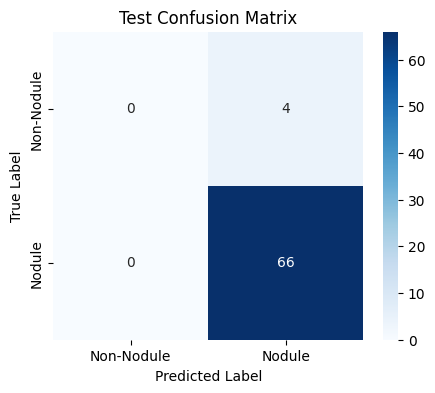

📊 Validation Classification Report:
               precision    recall  f1-score   support

  Non-Nodule       0.00      0.00      0.00         3
      Nodule       0.96      1.00      0.98        66

    accuracy                           0.96        69
   macro avg       0.48      0.50      0.49        69
weighted avg       0.91      0.96      0.94        69

📊 Test Classification Report:
               precision    recall  f1-score   support

  Non-Nodule       0.00      0.00      0.00         4
      Nodule       0.94      1.00      0.97        66

    accuracy                           0.94        70
   macro avg       0.47      0.50      0.49        70
weighted avg       0.89      0.94      0.92        70



c:\Users\emada\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\emada\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\emada\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [15]:
# ✅ 2️⃣ Performance Metrics (Confusion Matrix, ROC Curve, Precision-Recall)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc


# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, dataset_type="Validation"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Non-Nodule", "Nodule"],
        yticklabels=["Non-Nodule", "Nodule"],
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"{dataset_type} Confusion Matrix")
    plt.show()


# Plot confusion matrices
plot_confusion_matrix(val_labels, val_preds, "Validation")
plot_confusion_matrix(test_labels, test_preds, "Test")

# Classification Report
print(
    "📊 Validation Classification Report:\n",
    classification_report(val_labels, val_preds, target_names=["Non-Nodule", "Nodule"]),
)
print(
    "📊 Test Classification Report:\n",
    classification_report(
        test_labels, test_preds, target_names=["Non-Nodule", "Nodule"]
    ),
)

In [16]:
from collections import Counter
import os


def count_images_in_folders(base_dir):
    for split in ["train", "val", "test"]:
        for category in ["nodules", "non_nodules"]:
            folder = os.path.join(base_dir, split, category)
            count = len(os.listdir(folder))
            print(f"{split.capitalize()} - {category}: {count} images")


count_images_in_folders("dataset_split")

Train - nodules: 308 images
Train - non_nodules: 16 images
Val - nodules: 66 images
Val - non_nodules: 3 images
Test - nodules: 66 images
Test - non_nodules: 4 images
